In [1]:
! pip install pywph==1.0

Reason for being yanked: Wrong requirements.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pywph as pw
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
import time
import scipy.optimize as opt

In [3]:
# importing files from google drive
from google.colab import drive
drive.mount('/content/drive')

nbody = np.load('drive/MyDrive/camels data/Maps_Mtot_Nbody_SIMBA_LH_z=0.00.npy')
mgas = np.load('drive/MyDrive/camels data/Maps_Mgas_SIMBA_LH_z=0.00.npy')

Mounted at /content/drive


In [4]:
M, N = 256, 256
J = 7
L = 8
dn = 0

nbody_data = np.log(np.copy(nbody[0]))
mgas_data = np.log(np.copy(mgas[0]))

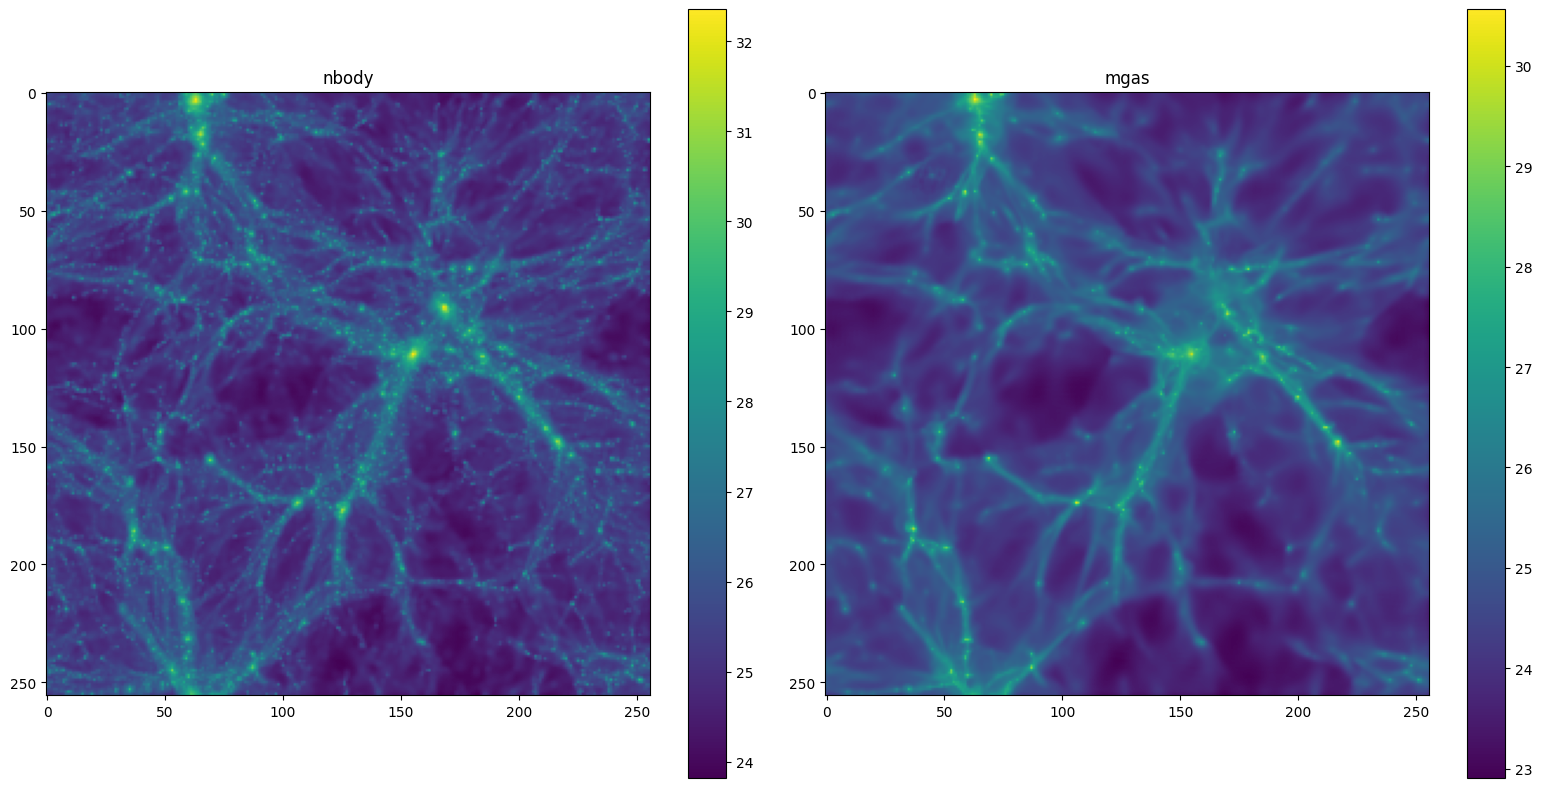

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

axs[0].set_title('nbody')
axs[1].set_title('mgas')

a1 = axs[0].imshow(nbody_data)
fig.colorbar(a1)
a2 = axs[1].imshow(mgas_data)
fig.colorbar(a2)

fig.tight_layout()
fig.show()

In [6]:
wph_op = pw.WPHOp(M, N, J, L=L, dn=dn, device=0) # operator
wph_op.load_model(cross_moments=True)

# get joint coefficients
norm = 'auto'
coeff1 = wph_op(nbody_data, norm=norm, pbc=True)
coeff2 = wph_op(mgas_data, norm=norm, pbc=True)
coeff12 = wph_op([nbody_data, mgas_data], cross=True, norm=norm, pbc=True)
coeff21 = wph_op([mgas_data, nbody_data], cross=True, norm=norm, pbc=True)
print(coeff1.shape)

/usr/local/lib/python3.10/dist-packages/pywph/wph_operator.py:774: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:276.)
  xpsi1_k1 -= mean1.to(xpsi1_k1.dtype) # Consistent dtype needed


torch.Size([3264])


In [7]:
# run on a GPU device
if torch.cuda.is_available():
    wph_op.to(0)

In [22]:
# generate a noise image as an initial guess

g1 = np.random.normal(nbody_data.mean(), nbody_data.std(), (M, N))
g2 = np.random.normal(mgas_data.mean(), mgas_data.std(), (M, N))
guess = np.array([g1,g2])
print(guess.shape)

(2, 256, 256)


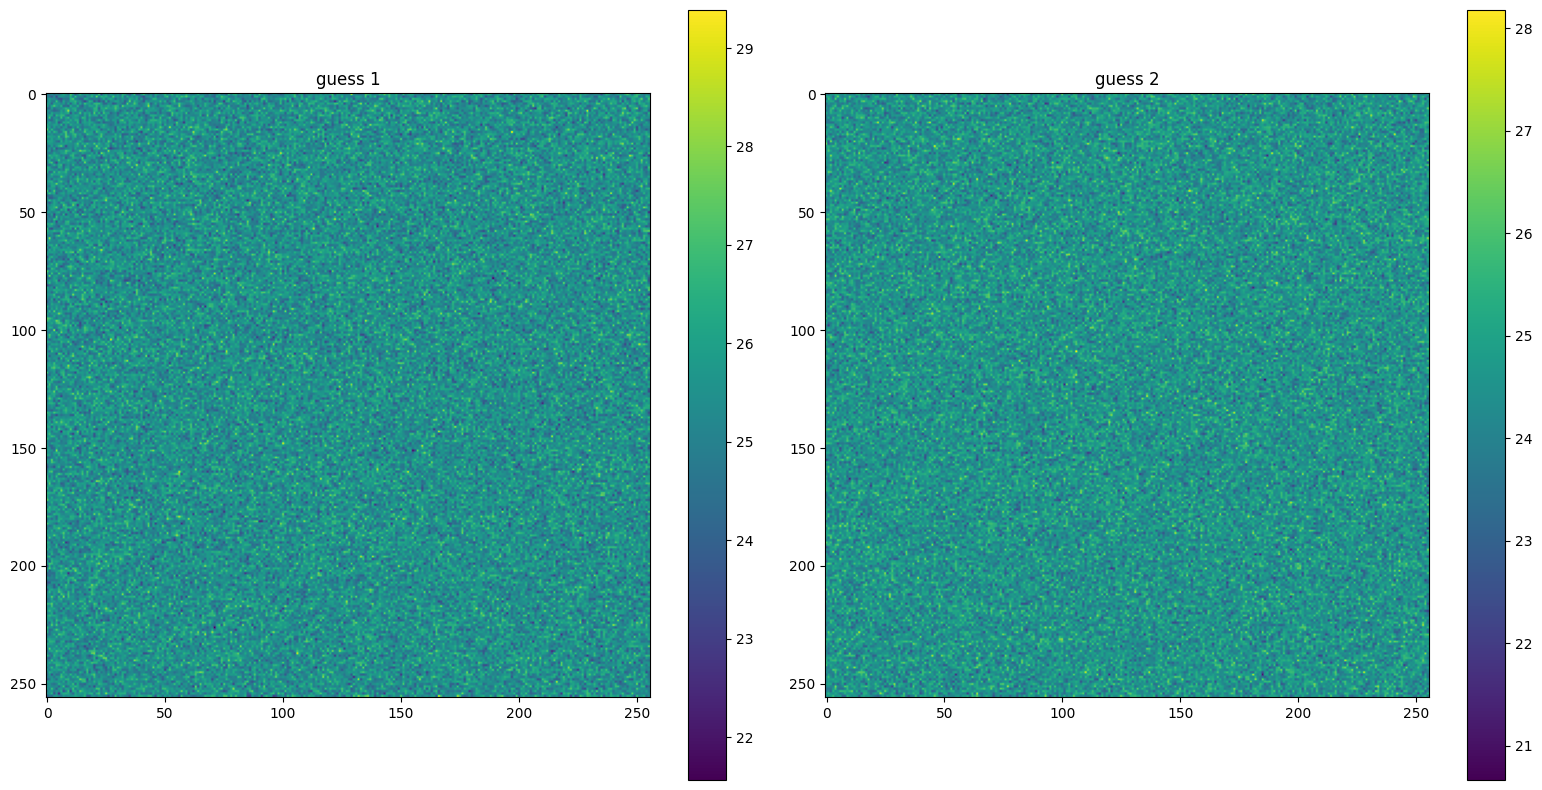

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].set_title('guess 1')
axs[1].set_title('guess 2')

a1 = axs[0].imshow(g1)
fig.colorbar(a1)
a2 = axs[1].imshow(g2)
fig.colorbar(a2)

fig.tight_layout()
fig.show()

In [25]:
# optimizer
device = 0
eval_cnt = 0
def objective1(x):

    global eval_cnt
    print(f"Evaluation: {eval_cnt}")
    start_time = time.time()
    # Reshape x
    x_curr = x.reshape((2, M, N))
    x_curr = pw.to_torch(x_curr, device=device)
    x_curr.requires_grad = True
    x_curr1 = x_curr[0]
    x_curr2 = x_curr[1]

    # Compute the loss (squared 2-norm)
    loss_tot = torch.zeros(1)

    x_curr1, nb_chunks = wph_op.preconfigure(x_curr1)
    for i in range(nb_chunks):
        coeffs_chunk, indices = wph_op.apply(x_curr1, i, norm=norm, ret_indices=True)
        loss = torch.sum(torch.abs(coeffs_chunk - coeff1[indices]) ** 2)
        loss.backward(retain_graph=True)
        loss_tot += loss.detach().cpu()
        del coeffs_chunk, indices, loss

    # Reshape the gradient
    x_grad = x_curr.grad.cpu().numpy().astype(x.dtype)
    print(f"Loss: {loss_tot.item()} (computed in {time.time() - start_time}s)")
    eval_cnt += 1

    return loss_tot.item(), x_grad.ravel()

In [26]:
eval_cnt = 0
def objective2(x):

    global eval_cnt
    print(f"Evaluation: {eval_cnt}")
    start_time = time.time()
    # Reshape x
    x_curr = x.reshape((2, M, N))
    x_curr = pw.to_torch(x_curr, device=device)
    x_curr.requires_grad = True
    x_curr1 = x_curr[0]
    x_curr2 = x_curr[1]

    # Compute the loss (squared 2-norm)
    loss_tot = torch.zeros(1)

    x_curr2, nb_chunks = wph_op.preconfigure(x_curr2)
    for i in range(nb_chunks):
        coeffs_chunk, indices = wph_op.apply(x_curr2, i, norm=norm, ret_indices=True)
        loss = torch.sum(torch.abs(coeffs_chunk - coeff2[indices]) ** 2)
        loss.backward(retain_graph=True)
        loss_tot += loss.detach().cpu()
        del coeffs_chunk, indices, loss

    # Reshape the gradient
    x_grad = x_curr.grad.cpu().numpy().astype(x.dtype)
    print(f"Loss: {loss_tot.item()} (computed in {time.time() - start_time}s)")
    eval_cnt += 1

    return loss_tot.item(), x_grad.ravel()

In [27]:
eval_cnt = 0
def objective3(x):

    global eval_cnt
    print(f"Evaluation: {eval_cnt}")
    start_time = time.time()
    # Reshape x
    x_curr = x.reshape((2, M, N))
    x_curr = pw.to_torch(x_curr, device=device)
    x_curr.requires_grad = True
    x_curr1 = x_curr[0]
    x_curr2 = x_curr[1]

    # Compute the loss (squared 2-norm)
    loss_tot = torch.zeros(1)
    x_curr_couple12, nb_chunks = wph_op.preconfigure([x_curr1, x_curr2], cross=True)
    for i in range(nb_chunks):
        coeffs_chunk12, indices = wph_op.apply(x_curr_couple12, i, norm=norm, ret_indices=True, cross=True)
        loss = torch.sum(torch.abs(coeffs_chunk12 - coeff12[indices]) ** 2)
        loss.backward(retain_graph=True)
        loss_tot += loss.detach().cpu()
        del coeffs_chunk12, indices, loss

    x_curr_couple21, nb_chunks = wph_op.preconfigure([x_curr2, x_curr1], cross=True)
    for i in range(nb_chunks):
        coeffs_chunk21, indices = wph_op.apply(x_curr_couple21, i, norm=norm, ret_indices=True, cross=True)
        loss = torch.sum(torch.abs(coeffs_chunk21 - coeff21[indices]) ** 2)
        loss.backward(retain_graph=True)
        loss_tot += loss.detach().cpu()
        del coeffs_chunk21, indices, loss

    # Reshape the gradient
    x_grad = x_curr.grad.cpu().numpy().astype(x.dtype)
    print(f"Loss: {loss_tot.item()} (computed in {time.time() - start_time}s)")
    eval_cnt += 1

    return loss_tot.item(), x_grad.ravel()

In [ ]:
total_start_time = time.time()
optim_params = {"maxiter": 200, "gtol": 1e-14, "ftol": 1e-14, "maxcor": 20}
result = opt.minimize(objective1, guess.ravel(), method='L-BFGS-B', jac=True, tol=None, options=optim_params)
final_loss, x_final, niter, msg = result['fun'], result['x'], result['nit'], result['message']
print(f"Synthesis ended in {niter} iterations with optimizer message: {msg}")
print(f"Synthesis time: {time.time() - total_start_time}s")

x_final = x_final.reshape((2, M, N)).astype(np.float32)

In [ ]:
total_start_time = time.time()
result = opt.minimize(objective2, x_final.ravel(), method='L-BFGS-B', jac=True, tol=None, options=optim_params)
final_loss, x_final, niter, msg = result['fun'], result['x'], result['nit'], result['message']
print(f"Synthesis ended in {niter} iterations with optimizer message: {msg}")
print(f"Synthesis time: {time.time() - total_start_time}s")

x_final = x_final.reshape((2, M, N)).astype(np.float32)

In [31]:
total_start_time = time.time()
result = opt.minimize(objective3, x_final.ravel(), method='L-BFGS-B', jac=True, tol=None, options=optim_params)
final_loss, x_final, niter, msg = result['fun'], result['x'], result['nit'], result['message']
print(f"Synthesis ended in {niter} iterations with optimizer message: {msg}")
print(f"Synthesis time: {time.time() - total_start_time}s")

x_final = x_final.reshape((2, M, N)).astype(np.float32)

Evaluation: 478
Loss: 10879.5712890625 (computed in 1.7360363006591797s)
Evaluation: 479
Loss: 10393.19921875 (computed in 1.7267789840698242s)
Evaluation: 480
Loss: 8448.00390625 (computed in 1.7282426357269287s)
Evaluation: 481
Loss: 1776.7857666015625 (computed in 1.723433017730713s)
Evaluation: 482
Loss: 23939.60546875 (computed in 1.724757432937622s)
Evaluation: 483
Loss: 512.3204956054688 (computed in 1.7245864868164062s)
Evaluation: 484
Loss: 483.0738830566406 (computed in 1.729032039642334s)
Evaluation: 485
Loss: 478.40863037109375 (computed in 1.742689609527588s)
Evaluation: 486
Loss: 477.69537353515625 (computed in 1.7582049369812012s)
Evaluation: 487
Loss: 474.9602355957031 (computed in 1.7244751453399658s)
Evaluation: 488
Loss: 465.8316650390625 (computed in 1.7251317501068115s)
Evaluation: 489
Loss: 410.82916259765625 (computed in 1.7264840602874756s)
Evaluation: 490
Loss: 389.0749206542969 (computed in 1.7218966484069824s)
Evaluation: 491
Loss: 312.34033203125 (computed i

In [32]:
final_guess = x_final
sim1 = final_guess[0]
sim2 = final_guess[1]

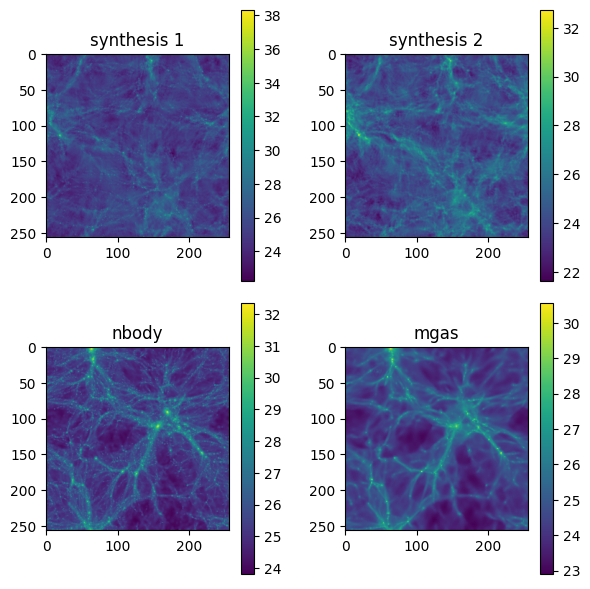

In [33]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6))

axs[0,0].imshow(sim1)
axs[0,1].imshow(sim2)
axs[1,0].imshow(nbody_data)
axs[1,1].imshow(mgas_data)

axs[0,0].set_title('synthesis 1')
axs[0,1].set_title('synthesis 2')
axs[1,0].set_title('nbody')
axs[1,1].set_title('mgas')#######('mgas')

a1 = axs[0,0].imshow(sim1)
fig.colorbar(a1)
a2 = axs[0,1].imshow(sim2)
fig.colorbar(a2)
a3 = axs[1,0].imshow(nbody_data)
fig.colorbar(a3)
a4 = axs[1,1].imshow(mgas_data)
fig.colorbar(a4)
fig.tight_layout()
fig.show()

In [48]:
wph1 = wph_op(sim1, ret_wph_obj=True) # WPH object
s11_guess_1 = wph1.get_coeffs("S11")[0]
wph2 = wph_op(sim2, ret_wph_obj=True)
s11_guess_2 = wph2.get_coeffs("S11")[0]

wph_nbody = wph_op(nbody_data, ret_wph_obj=True)
s11_nbody = wph_nbody.get_coeffs("S11")[0]

wph_mstar = wph_op(mgas_data, ret_wph_obj=True)
s11_mgas = wph_mstar.get_coeffs("S11")[0]

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


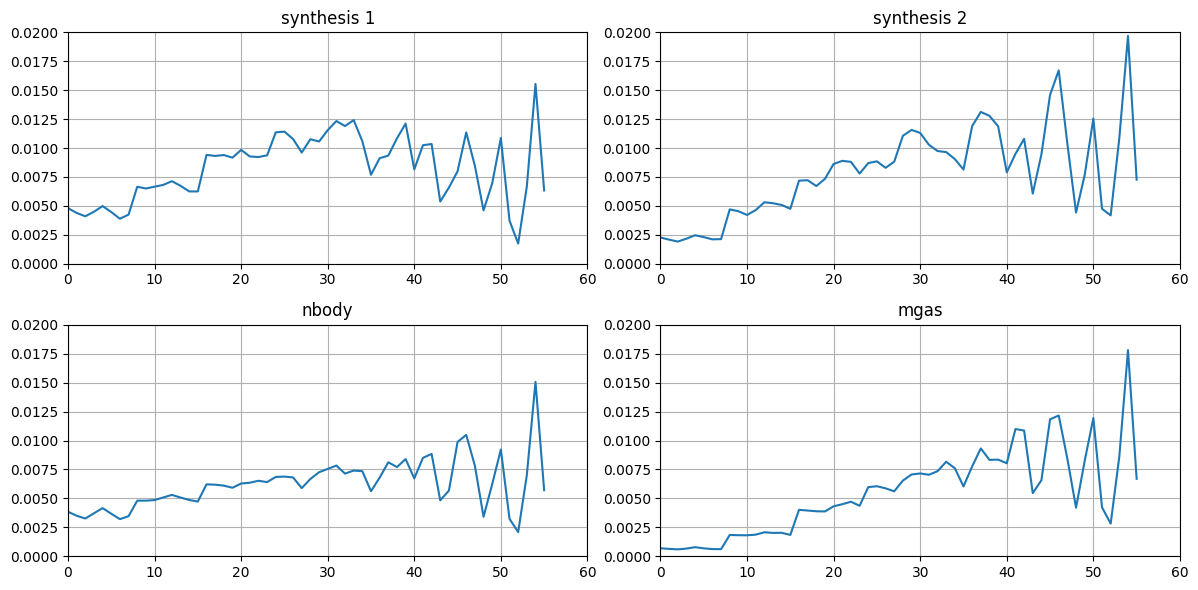

In [49]:
# compare S11 coefficients
fig, axs = plt.subplots(2, 2, figsize=(12, 6))

axs[0,0].plot(s11_guess_1)
axs[0,1].plot(s11_guess_2)
axs[1,0].plot(s11_nbody)
axs[1,1].plot(s11_mgas)

axs[0,0].set_title('synthesis 1')
axs[0,1].set_title('synthesis 2')
axs[1,0].set_title('nbody')
axs[1,1].set_title('mgas')

for i in range(2):
    for j in range(2):
      axs[i,j].set_xlim(0,60)
      axs[i,j].set_ylim(0,0.02)
      axs[i,j].grid()


fig.tight_layout()
fig.show()

In [50]:
wph1 = wph_op(sim1, ret_wph_obj=True) # WPH object
s10_guess_1 = wph1.get_coeffs("S10")[0]
wph2 = wph_op(sim2, ret_wph_obj=True)
s10_guess_2 = wph2.get_coeffs("S10")[0]

wph_nbody = wph_op(nbody_data, ret_wph_obj=True)
s10_nbody = wph_nbody.get_coeffs("S10")[0]

wph_mstar = wph_op(mgas_data, ret_wph_obj=True)
s10_mgas = wph_mstar.get_coeffs("S10")[0]

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


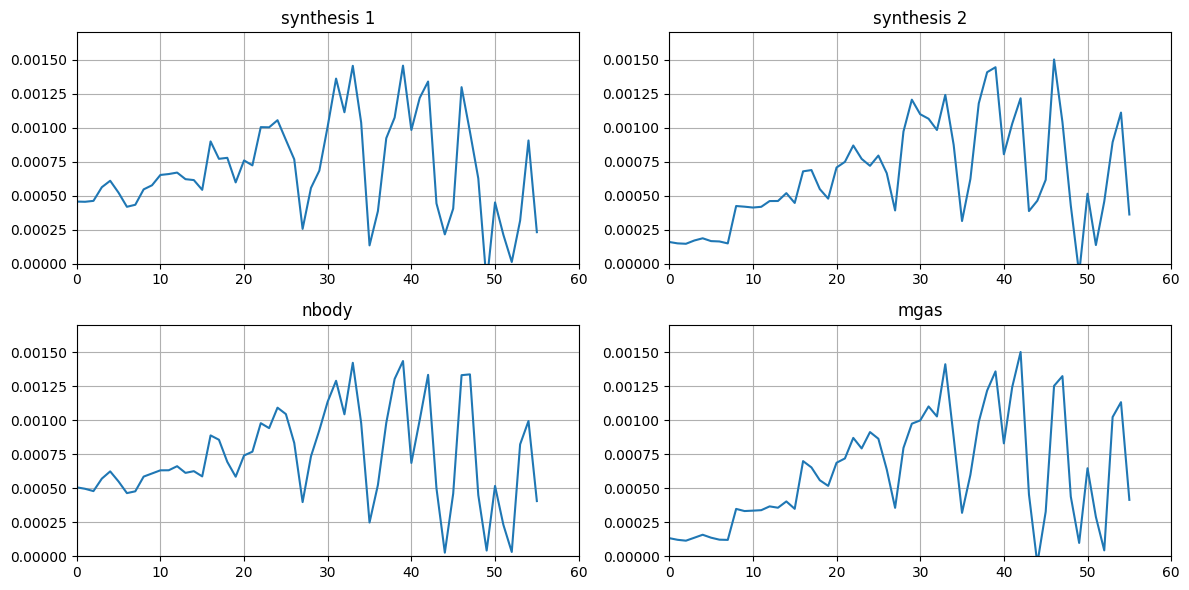

In [51]:
# compare S10 coefficients
fig, axs = plt.subplots(2, 2, figsize=(12, 6))

axs[0,0].plot(s10_guess_1)
axs[0,1].plot(s10_guess_2)
axs[1,0].plot(s10_nbody)
axs[1,1].plot(s10_mgas)

axs[0,0].set_title('synthesis 1')
axs[0,1].set_title('synthesis 2')
axs[1,0].set_title('nbody')
axs[1,1].set_title('mgas')

for i in range(2):
    for j in range(2):
      axs[i,j].set_xlim(0,60)
      axs[i,j].set_ylim(0,0.0017)
      axs[i,j].grid()


fig.tight_layout()
fig.show()